# IMDB Reviews Sentiment Analysis

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
from fastai import *
from fastai.text import *

## Getting the Dataset

Total of 100K reviews:
* 25K labeled positive or negative, used for training
* 25K set aside for testing (contains both neg and pos)
* 50K unlabelled

Thanks to Andrew Maas et al. who created the dataset.

We'll start by exploring a small sample of the full dataset:

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/tmp'),
 PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Each line in the .csv file contains two columns, the first is a label, and the second is a full review.

## Processing the Data
In order to get our text data ready for a neural network, we need to convert them to numbers. This is done in two steps:
* tokenization
* numericalization

`TextDataBunch` does this all behind the scenes

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [7]:
data_lm.save()

Running the above line saves the preprocessed text data to the disk, and running the following line if/when we re-open this notebook again is all that needs to be done to resume work.

In [8]:
data = TextDataBunch.load(path)

### Tokenization

Tokenization is the first processing step for text data. It splits sentences into tokens, which most often, but not always, take the shape of individual words. 

We split up the text based on spaces, but we also consider:
* Punctuation
* Contractions that connect what were originally two separate words, resulting in words like *isn't* or *hadn't*
* Clean up any strange strings that don't contain meaning, such as any stray HTML code, for example.

Here's some of what our tokenizer did behind the scenes:

In [9]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might , no matter how warm and gooey raising victor vargas became i was always aware that something did n't quite feel right . victor vargas suffers from a certain xxunk on the director 's part . apparently , the director thought that the ethnic backdrop of a latino family on the",negative
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying to watch a film director change his style / subject , but soderbergh 's most recent stinker , the girlfriend xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be soderbergh 's main challenge . strange , after xxunk years",negative
"xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . with graphics that are terribly dated today , the game xxunk you into the role of xxunk even * think * i 'm going to attempt spelling his last name ! ) , an american",positive
"xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . the only problem is half of them are straight and james does n't know this . if",negative
"xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the format is the same as max xxunk ' "" la xxunk , "" based on a play by arthur xxunk , who is given an "" inspired by "" credit . it starts from one person , a prostitute , standing on a street xxunk in brooklyn . she is picked",positive
"xxfld 1 how viewers react to this new "" adaption "" of shirley jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one ... and those who have never been exposed to either , and who are big fans of hollywood 's current trend towards "" special effects "" being the first and last word",negative
"xxfld 1 to review this movie , i without any doubt would have to quote that memorable scene in tarantino 's "" pulp fiction "" ( xxunk ) when jules and vincent are talking about mia wallace and what she does for a living . jules tells vincent that the "" only thing she did worthwhile was pilot "" . vincent asks "" what the hell is a pilot ? "" and jules goes into a very well description of what a tv pilot is : "" well , the way they make shows is , they make one show",negative
"xxfld 1 \n\n i 'm sure things did n't exactly go the same way in the real life of homer hickam as they did in the film adaptation of his book , rocket boys , but the movie "" october sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read hickam 's memoirs , but i am still able to enjoy and understand their film adaptation . the film , directed by joe xxunk and written by lewis xxunk , xxunk the story of teenager homer hickam (",positive
"xxfld 1 well , what can i say . \n\n "" what the xxunk do we know "" has achieved the nearly impossibl

The text above gives examples of our tokenizer separating text based on:
* "'s" all appear as single tokens
* Separated contractions: "did" and "n't"
* Content has all been lower-cased
* All HTML symbols are gone
* Several tokens begin with "xx"
    * "xxunk" replaces unknown words
    * "xxfld 1" indicates the beginning of a new text field (our reviews each contain only one field)

### Numericalization

After extracting tokens, we convert them all to integers according to this process:
1. Create a list of all the words used
* Keep only the tokens that appear twice, up to a maximum total vocab size of 60,000 (default value)
* All rarer words are replaced with the unknown token `unk`

The list we generate is called `itos` (int to string), and is stored in the `vocab` attribute of our dataset.

In [10]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

If we look at our actual data that's shortly going to be fed to a deep neural network, we see it's now just lists of numbers:

In [11]:
data.train_ds[0][0][:10]

[43, 40, 34, 170, 61, 6, 350, 3, 46, 1492]

### Datablock API

In the cells above, fastai's defaults took care of splitting off a validation set. Unfortunately, we already have a validation set that's been set aside, which we want to be able to tell fastai to use.

The datablock API lets us do this (order of steps matters):

In [12]:
data = (TextSplitData.from_csv(path, 'texts.csv', input_cols=1, label_cols=0, valid_col=2)
        .datasets(TextDataset) # Specify type of dataset here
        .tokenize() # Could specify custom args for tokenization if desired
        .numericalize() # Could also specify custom args for numericalization
        .databunch(TextDataBunch)) # Specify type of databunch

## Grabbing the Full Dataset

It's good to use a small subset of our full dataset when performing initial exploration and determining the best way to store, label, and preprocess the data.

Once we've got a strategy figured out, we can begin to work the the full dataset.

In [13]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models')]

In [14]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsup')]

The data is stored inside pos and neg directories, each inside train and test directories. This is similar to how the imagenet data is organized. The only difference is the directory `unsup` for the unlabelled data, which also appears in the train and test directories.

## Transfer Learning for Language Models

We can build text models using transfer learning, just like we did for images. In our case, we'll make use of a model that's already been trained to recognize English.

The model we will use has been trained on a cleaned subset of Wikipedia, called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset). This model has been trained to guess the next word that follows a sequence of words fed in as input.

This model has a "hidden state" which is updated everytime it sees a new word. In other words, the model has a "recurrent" structure.

We will need to fine-tune this model so that it can become familiar with the uniqueness of our own IMDB dataset. Here are a few ways we expect our data to be different from the English lanaguage dataset originally used to train the model:
* There may be words our IMDB reviews that are missing from the Wikipedia text data the model was originally trained on.
* The the purpose/style of Wikipedia entries (explaining) are fairly different from IMDB reviews (opining)

This is where the unlabelled data will be useful -- we can use it to fine-tune our model to get better at understanding "IMDB"-style English. Once we've accomplished that, we can finally train it to distinguish whether a review is positive or negative.

## Training the base model to understand "IMDB"-style English

In [22]:
bs=32

data_lm = (TextFileList.from_folder(path) # Grab all text files in the path
           .label_const(0) # Label them all with 0s (because we don't yet care about pos. vs neg. reviews)
           .split_by_folder(valid='test') # Split by folder between train and val set
           .datasets() # Using TextDataSet with flag is_fnames=True instructs to read the content inside files
           .tokenize() # Tokenize with fastai defaults
           .numericalize() # Numericalize with fastai defaults
           .databunch(TextLMDataBunch, bs=bs)) # Use a TextLMDataBunch)

data_lm.save('tmp_lm')

The `TextLMDataBunch` that we use here ignores the labels (that's why we put "0" for each label) and shuffles the texts at each epoch before concatenating them all together. (Note that this only happens for training, and we don't shuffle the validation set.)

Why do we shuffle and then concatenate all the training text together? It's so that we can subdivide the giant, long string into smaller mini-batches. During each epoch, our data loader grabs successive chunks from this shuffled, long string, and feeds them into the neural network.

In [23]:
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


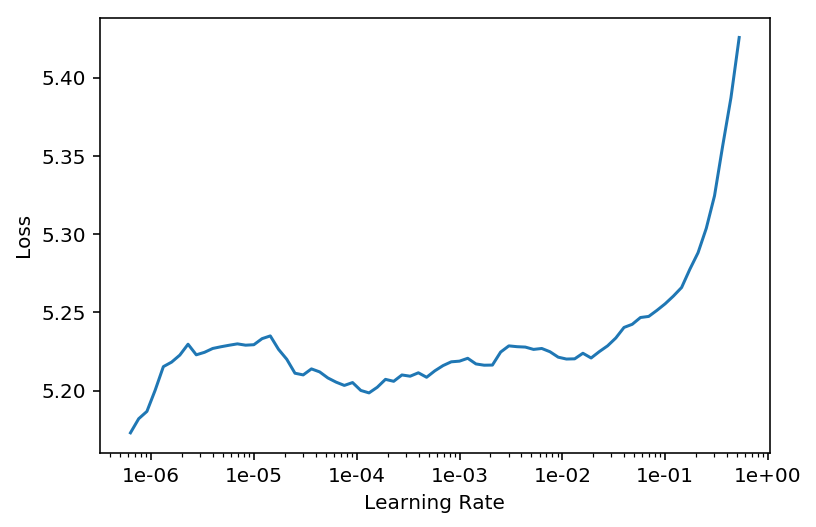

In [17]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 45:18
epoch  train_loss  valid_loss  accuracy
1      4.699918    4.539618    0.246406  (45:18)



In [19]:
learn.save('fit_head')

In [17]:
learn.load('fit_head');

In [18]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


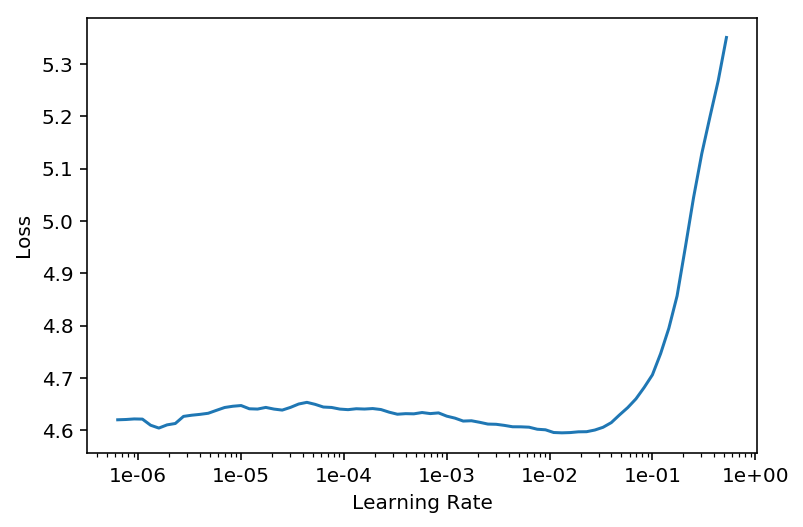

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [20]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 8:29:19
epoch  train_loss  valid_loss  accuracy
1      4.382264    4.323878    0.267432  (50:55)
2      4.304178    4.258223    0.277471  (51:04)
3      4.299090    4.223635    0.282155  (50:55)
4      4.237304    4.183446    0.286842  (51:00)
5      4.172203    4.154258    0.290216  (50:58)
6      4.106487    4.125678    0.293273  (50:48)
7      4.093341    4.111899    0.295516  (50:51)
8      3.992854    4.098719    0.297349  (50:53)
9      3.950101    4.093769    0.298051  (50:57)
10     3.901410    4.093699    0.298093  (50:53)



In [21]:
learn.save('fine_tuned')

We save the model, as usual, but for our final classification task, we really only care about the part of the model that creates and updates the hidden state -- we don't need to try and guess the next word of our IMDB reviews, we only need a model that can "understand" their English.

The `encoder` is the part of our model that is responsible for updating its hidden state.

In [22]:
learn.save_encoder('fine_tuned_enc')

## Training the Final Classifier

Now we create a new data object that grabs the labelled IMDB data and keeps those labels.

In [25]:
bs=32

data_clas = (TextFileList.from_folder(path) # Grab all text files in the path
             .label_from_folder(classes=['neg', 'pos']) # Label each with their folder's name; only keep 'neg' and 'pos'
             .split_by_folder(valid='test') # Split by folder between train and validation sets
             .datasets() # Use TestDataSet, with flag is_fnames=True to read content from the files passed
             .tokenize() # Tokenize with fastai's defaults
             .numericalize(vocab = data_lm.vocab) # Numericalize with same vocabulary as pre-trained model
             .databunch(TextClasDataBunch, bs=bs))

data_clas.save('tmp_clas')

In [24]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=32)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both opponents have to go through tables in order to get the win . benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray . a german suplex by benoit to bubba took the wind out of the dudley brother . spike tried to",pos
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in sydney , after xxunk ) , i can xxunk join both hosts of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying to watch a film director change his style / subject , but soderbergh 's most recent stinker , the girlfriend xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be soderbergh 's main challenge . strange , after 20-odd years",neg
"xxfld 1 xxup spoilers xxup herein \n\n my high school did all they could to try and motivate us for exams . but the most memorable method they used to get us into the right state of mind was a guest speaker , who was none other than australian kickboxing 's favorite son , stan "" the man "" xxunk . the first mistake they made was giving this guy a microphone , because he was screaming half the time despite us sitting no more than 3 or 4 feet away from him . now , his speech was full",neg
"xxfld 1 i tried to remove anything that might be considered a spoiler . i also assume that you 've seen the first movie or at least know the general gist , so if you have n't some of this might not make sense . \n\n plot : this movie beats the audience over the head with tired philosophical ramblings again and again in an attempt to get the theme across . we are bombarded again and again by questions of purpose , and destiny , and choice , and forced to endure the long , torturous platitude sessions that",neg
"xxfld 1 xxup warning : xxup possible xxup spoilers ( but not really - keep reading ) . ahhh , there are so many reasons to become utterly addicted to this spoof gem that i wo n't have room to list them all . the opening credits set the playful scene with kitsch late 1950s cartoon stills ; an enchanting xxunk ' prez ' prado mambo theme which appears to be curiously uncredited ( but his grunts are unmistakable , and no - one else did them ) ; and with familiar cast names , including kathy xxunk a full",pos
"xxfld 1 well , maybe the pc version of this game was impressive . maybe . i just finished playing the xxup ps2 version and it 's pretty much a complete mess . \n\n there are a couple elements that are okay or promising . i 'll mention those first because it will be over quickly . first , the idea of a historical xxup gta - like game is a great one . the game gun was a historical xxup gta - like game and unlike mafia , gun was excellent . i 'd love to see a game",neg
"xxfld 1 . . . and that 's a bad thing , because at least if this had been a troma film , it would have had wanton violence and a greater sense of anarchic abandon that might have brought my rating up a bit . \n\n so what we have instead is a very tame ( rated pg ) , barely lukewarm , low budget ( roger corman produced it with an unknown director who has subsequently remained unknown ) gremlins ( 1984 ) / critters ( xxunk with almost exclusively flat humor , little of the logic that",neg
"xxfld 1 i have to admit that i went into fever pitch with low expectations . it 's no huge revelation for me to say that jimmy fallon 's last movie ( taxi ) was xxunk bad , and the trailers for fever pitch were all right but did n't mesmerize me . i was already preparing some cheesy baseball puns for my review ... \n\n "" i like jimmy fallon , but taxi was strike one in his movie career . well , now we 've got st xxrep 6 e -r xxrep 6 i ke xxunk xxrep 8"

In [26]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


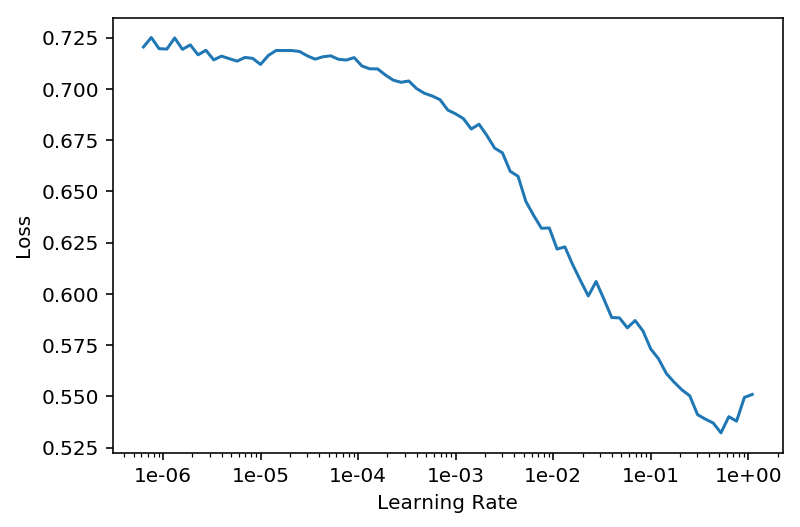

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 15:39
epoch  train_loss  valid_loss  accuracy
1      0.307629    0.225676    0.914160  (15:39)



In [28]:
learn.save('first')

In [29]:
learn.load('first');

#### On Unfreezing:

When training an NLP model, it's best to use a training regime where the number of unfreezed layers gradually increases with each training round. 

Here, we unfreeze the top layer, train an epoch, then unfreeze the top 2 layers and then train, unfreeze the top 3 layers and train once more, and finally unfreeze all layers and train a final round of two epochs.

#### On Choice of Discriminative Learning Rates:

Jeremy found that dividing the learning rate used to train the lowest layers by 2.6^4 and then gradually increasing this rate, until the un-reduced learning rate is used to train the top layer, gives the highest accuracy for NLP models.

He determined this by running an experiment where a random forest regressor was trained on results several NLP training experiments. The random forest regressor predicted that dividing lr/2.6^4 was a good choice for initial learning rate, and increasing layer by layer to a max of lr would give the highest accuracies.

In [30]:
learn.freeze_to(-2) # Un-freeze final two layers for this round
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 16:35
epoch  train_loss  valid_loss  accuracy
1      0.269390    0.183443    0.931800  (16:35)



In [31]:
learn.save('second')

In [32]:
learn.load('second');

In [33]:
learn.freeze_to(-3) # Now un-freeze final three layers
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 22:32
epoch  train_loss  valid_loss  accuracy
1      0.249568    0.174062    0.938360  (22:32)



In [34]:
learn.save('third')

Need to decrease batch size when training all the layers.

In [27]:
bs=20

data_clas = (TextFileList.from_folder(path) # Grab all text files in the path
             .label_from_folder(classes=['neg', 'pos']) # Label each with their folder's name; only keep 'neg' and 'pos'
             .split_by_folder(valid='test') # Split by folder between train and validation sets
             .datasets() # Use TestDataSet, with flag is_fnames=True to read content from the files passed
             .tokenize() # Tokenize with fastai's defaults
             .numericalize(vocab = data_lm.vocab) # Numericalize with same vocabulary as pre-trained model
             .databunch(TextClasDataBunch, bs=bs))

data_clas.save('tmp_clas')

In [31]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [32]:
learn.load('third');

In [ ]:
learn.unfreeze() # Only now do we finally unfreeze all layers
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.271587,0.177732,0.932920
2,0.232312,0.162377,0.940960
3,0.249751,0.159572,0.942400
4,0.192949,0.158286,0.942640
5,0.176982,0.161233,0.940960
6,0.169089,0.157861,0.942480
7,0.151231,0.159388,0.942760
8,0.146805,0.163748,0.941280
9,0.136502,0.159782,0.942400


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
# Training completed through ten epochs. Above cell stopped 
# registering output just before completion. 
learn.save('imdb-clas-final')

## Final Results

In [35]:
learn.load('imdb-clas-final');

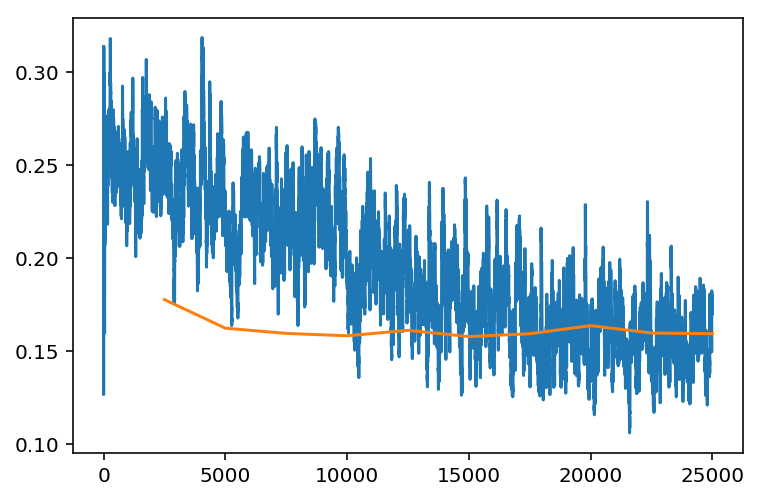

In [36]:
learn.recorder.plot_losses()

In [53]:
learn.recorder.losses[24999]

tensor(0.1773, device='cuda:0')

In [61]:
learn.recorder.val_losses[9]

0.15939298

Even after ten epochs, we still see that we're underfitting, as the val loss of `0.15939298` is less than the train loss of `0.1773`.

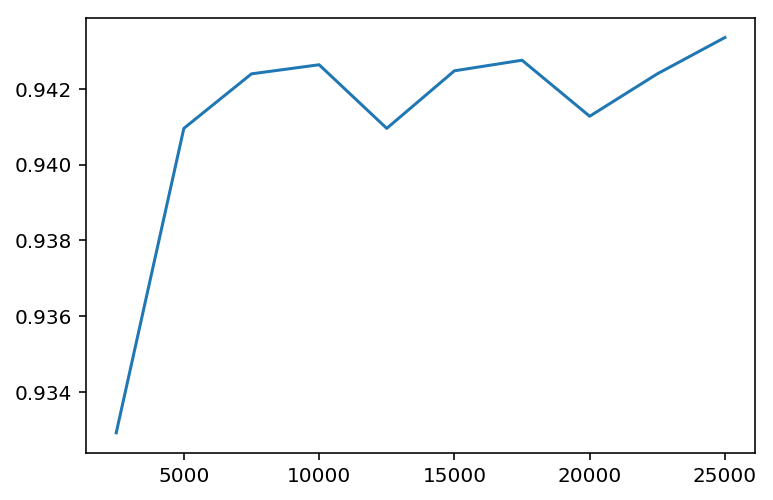

In [37]:
learn.recorder.plot_metrics()

In [50]:
learn.recorder.metrics

[[tensor(0.9329)],
 [tensor(0.9410)],
 [tensor(0.9424)],
 [tensor(0.9426)],
 [tensor(0.9410)],
 [tensor(0.9425)],
 [tensor(0.9428)],
 [tensor(0.9413)],
 [tensor(0.9424)],
 [tensor(0.9434)]]

Got a top accuracy of `94.34%` at the tenth and final training epoch.